In [1]:
from __future__ import division, print_function

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as spd
from scipy.stats import gaussian_kde

from sklearn.cluster import KMeans

import keras
import keras.backend as K
from keras.constraints import maxnorm
from keras.layers import Activation, Dense, Dropout, GaussianNoise, Input
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


# Adjust the plotting style

Let us borrow the beautiful stylesheets from seaborn. Also change the actual colors represented by single-letter color codes such as 'b' or 'k' to corresponding colors in the seaborn stylesheets. This will ensure better visual consistency.

In [2]:
%matplotlib inline

plt.style.use('seaborn-muted')
plt.style.use('seaborn-whitegrid')

def set_matplotlib_colorcode(colors):
    for code, color in zip('bgrmyck', colors):
        rgb = mpl.colors.colorConverter.to_rgb(color)
        mpl.colors.colorConverter.colors[code] = rgb
        mpl.colors.colorConverter.cache[code] = rgb

COLORS = np.array([color['color'] for color in list(mpl.rcParams['axes.prop_cycle'])])
set_matplotlib_colorcode(COLORS)

<hr>

# Generate some dataset

Let us engineer 2-dimensional dataset that looks somewhat non-trivial.

In [3]:
NUM_DATA = 2000

def interesting_map(t):
    NUM_ITERATION = 23
    A = 1.1
    B = 1.8
    C = 1.2
    x = np.cos(t)
    y = np.sin(t)
    for _ in range(NUM_ITERATION):
        x = (x + np.tanh(A * (x + t * y)) + np.cos(y)) / C
        y = (y + np.tanh(B * (x - t * y)) + np.sin(x)) / C
    return np.transpose([x, y])

points = interesting_map(np.linspace(-6, 6, num=NUM_DATA))
points = (points - points.mean(axis=0)) / points.std(axis=0)
np.random.shuffle(points)

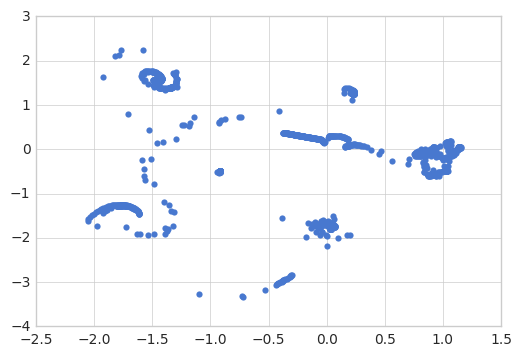

In [4]:
plt.scatter(points[:, 0], points[:, 1], lw=0)
pass

## Plot density estimates

Let us estimate the two-dimensional density distribution of the generated dataset using scipy's kernel density estimator.

In [5]:
density_func = gaussian_kde(points.T)

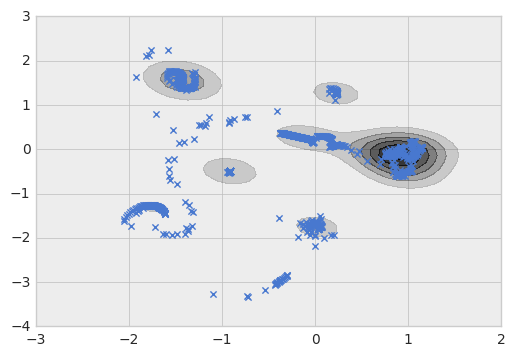

In [6]:
mesh_xs = np.linspace(-3, 2, num=50)
mesh_ys = np.linspace(-4, 3, num=50)
mesh_points = np.moveaxis(np.meshgrid(mesh_xs, mesh_ys), 0, 2).reshape(-1, 2)
density_values = density_func(mesh_points.T).reshape(len(mesh_xs), len(mesh_ys))
density_values = density_values

transparency_cmap = mpl.colors.LinearSegmentedColormap.from_list('', [
    (0, 0, 0, 0),
    (0, 0, 0, 1)
])

fig, ax = plt.subplots()
ax.contourf(mesh_xs, mesh_ys, density_values, cmap=transparency_cmap)
ax.scatter(points[:, 0], points[:, 1], marker='x')
ax.set_xlim(mesh_xs[0], mesh_xs[-1])
ax.set_ylim(mesh_ys[0], mesh_ys[-1])

pass

<hr>

# Cluster the data

Now let's play with the dataset. The points in the dataset look clustered to several groups. Can machine-learning techniques identify the clusters?

## K-means

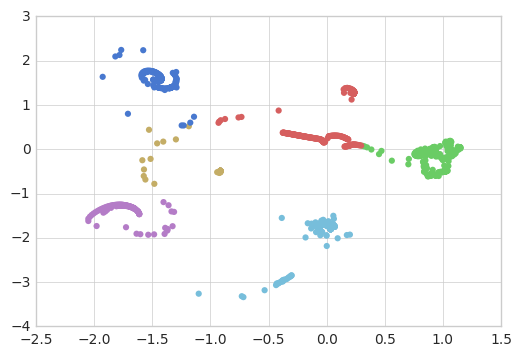

In [7]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(points)
labels = kmeans.predict(points)

plt.scatter(points[:, 0], points[:, 1], c=COLORS[labels], lw=0)

pass

## Agglomerative clustering (UPGMA)

scipy and sklearn both support agglomerative clustering of vectorial data. scipy has a utility function to plot the dendrogram of clustering result, so use it.

In [8]:
distances = spd.pdist(points)
distance_matrix = spd.squareform(distances)
cluster_linkage = sch.linkage(distances, method='average')

/usr/lib/python2.7/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


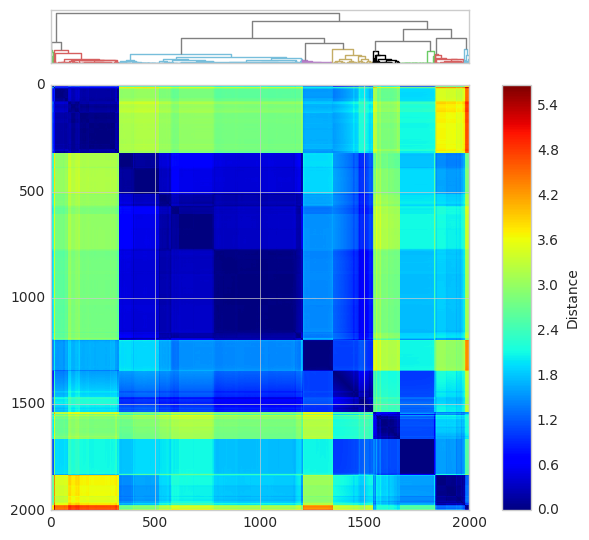

In [9]:
CLUSTER_CUTOFF = 1.0

fig = plt.figure(figsize=(6.0, 5.5), tight_layout=True)
gs = GridSpec(2, 2, width_ratios=[14, 1], height_ratios=[1, 8])

ax_dendro = fig.add_subplot(gs[0, 0])
ax_distance = fig.add_subplot(gs[1, 0])
ax_colorbar = fig.add_subplot(gs[1, 1])

dendro = sch.dendrogram(cluster_linkage,
                        color_threshold=CLUSTER_CUTOFF, distance_sort=True,
                        above_threshold_color='gray',
                        ax=ax_dendro, orientation='top', no_labels=True)
ax_dendro.set_xticks([])
ax_dendro.set_yticks([])

order = dendro['leaves']
clustered_distance_matrix = distance_matrix[:, order][order, :]
im = ax_distance.imshow(clustered_distance_matrix, cmap='jet', aspect='auto')
fig.colorbar(im, cax=ax_colorbar, label='Distance')

pass

# Model the dataset with a Generative Adversarial Network

## Define the architecture of discriminator and generator

In [10]:
DATA_DIM = 2
LATENT_DIM = 1

Here is the discriminator network...

In [11]:
# Discriminator
inp = Input(shape=(DATA_DIM, ))
net = GaussianNoise(0.01)(inp)

net = Dense(50, W_constraint=maxnorm(3), b_constraint=maxnorm(3), name='initial_dense')(net)
net = Activation('relu')(net)
net = Dropout(0.5)(net)

net = Dense(30, W_constraint=maxnorm(3), b_constraint=maxnorm(3), name='second_dense')(net)
net = Activation('relu')(net)
net = Dropout(0.3)(net)

net = Dense(10, W_constraint=maxnorm(3), b_constraint=maxnorm(3), name='third_dense')(net)
net = Activation('relu')(net)

net = Dense(1, name='output')(net)
net = Activation('sigmoid')(net)

discriminator = Model(inp, net)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.8e-4))

and the following is the generator network.

In [12]:
# Generator
inp = Input(shape=(LATENT_DIM, ))
net = inp

net = Dense(10, W_constraint=maxnorm(3), b_constraint=maxnorm(3), name='initial_dense')(net)
net = Activation('relu')(net)
net = Dropout(0.5)(net)

net = Dense(50, W_constraint=maxnorm(3), b_constraint=maxnorm(3), name='second_dense')(net)
net = Activation('relu')(net)
net = Dropout(0.3)(net)

net = Dense(100, W_constraint=maxnorm(3), b_constraint=maxnorm(3), name='third_dense')(net)
net = Activation('relu')(net)

net = Dense(DATA_DIM, name='output')(net)

generator = Model(inp, net)

In [13]:
def generate_latent_data(n):
    return np.random.uniform(-1, 1, size=(n, LATENT_DIM))

In [14]:
# Setting trainable False does not affect the already-compiled discriminator model.
# But this affects the GAN model constructed here, in which the parameters of the
# discriminator sub-network are frozen.
discriminator.trainable = False

latent = Input(shape=(LATENT_DIM, ))
response = discriminator(generator(latent))
gan = Model(latent, response)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.8e-4))

## Train the model

In [15]:
NUM_EPOCHS = 10000
BATCH_SIZE = 100
DECAY_TIMING = 100
DECAY_RATE = 0.97

def decay_learning_rate(model, epoch):
    # Step decay
    opt = model.optimizer
    if (epoch + 1) % DECAY_TIMING == 0:
        K.set_value(opt.lr, DECAY_RATE * K.get_value(opt.lr))

In [16]:
train_data = points
loss_history = {'discriminator': [], 'generator': []}

def make_progress_bar(cur, goal, width=30):
    prog = (cur * width + goal - 1) // goal
    return '=' * prog + ' ' * (width - prog)

for epoch in range(NUM_EPOCHS):
    print('Epoch {} of {} [{}]'.format(epoch + 1, NUM_EPOCHS, make_progress_bar(epoch, NUM_EPOCHS)), end='\r')

    decay_learning_rate(discriminator, epoch)
    decay_learning_rate(gan, epoch)

    n_batches = len(train_data) // BATCH_SIZE
    epoch_losses = []
    for batch in range(n_batches):
        # Let the generator create fake input, then train the discriminator
        # to correctly detect the fakes
        fake = generator.predict(generate_latent_data(BATCH_SIZE))
        real = train_data[(batch * BATCH_SIZE):((batch + 1) * BATCH_SIZE)]
        batch_input = np.concatenate([fake, real])
        expected_response = np.array([0] * BATCH_SIZE + [1] * BATCH_SIZE)
        discriminator_loss = discriminator.train_on_batch(batch_input, expected_response)

        # Train the generator through GAN to trick the discriminator
        batch_latent = generate_latent_data(len(batch_input))
        tricked_response = np.ones(2 * BATCH_SIZE)
        generator_loss = gan.train_on_batch(batch_latent, tricked_response)

        epoch_losses.append((discriminator_loss, generator_loss))

    discriminator_loss, generator_loss = np.mean(epoch_losses, axis=0)
    loss_history['discriminator'].append(discriminator_loss)
    loss_history['generator'].append(generator_loss)

## Diagnose the training result

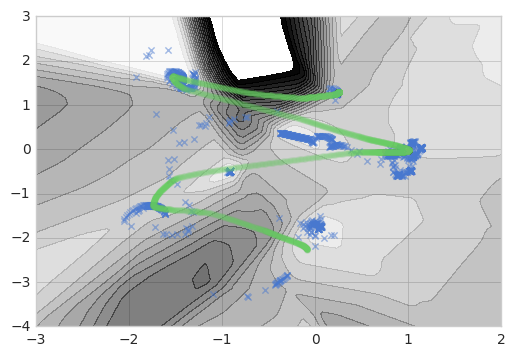

In [17]:
fake_points = generator.predict(np.linspace(-1, 1, num=5000))

mesh_xs = np.linspace(-3, 2, num=100)
mesh_ys = np.linspace(-4, 3, num=100)
mesh_points = np.moveaxis(np.meshgrid(mesh_xs, mesh_ys), 0, 2).reshape(-1, 2)
prob_values = discriminator.predict(mesh_points)
prob_map = prob_values.reshape(len(mesh_xs), len(mesh_ys))

probability_cmap = mpl.colors.LinearSegmentedColormap.from_list('', [
    (0, 0, 0, 1),
    (0, 0, 0, 0)
])

fig, ax = plt.subplots()
ax.contourf(mesh_xs, mesh_ys, prob_map,
            levels=np.logspace(-2, 0, num=20),
            norm=LogNorm(vmin=1e-2, vmax=1),
            cmap=probability_cmap)
ax.scatter(points[:, 0], points[:, 1], c=COLORS[0], marker='x', alpha=0.5)
ax.scatter(fake_points[:, 0], fake_points[:, 1], lw=0, c=COLORS[1], alpha=0.1)
ax.set_xlim(mesh_xs[0], mesh_xs[-1])
ax.set_ylim(mesh_ys[0], mesh_ys[-1])

pass

Blue crosses are the training data. Green line is the samples generated by the generator model. Background contour plot shows the probability density of the data predicted by the discriminator (white region has higher probability). The performance of the models is not very bad (not pretty good though). We can see that the green line traces the blue points.

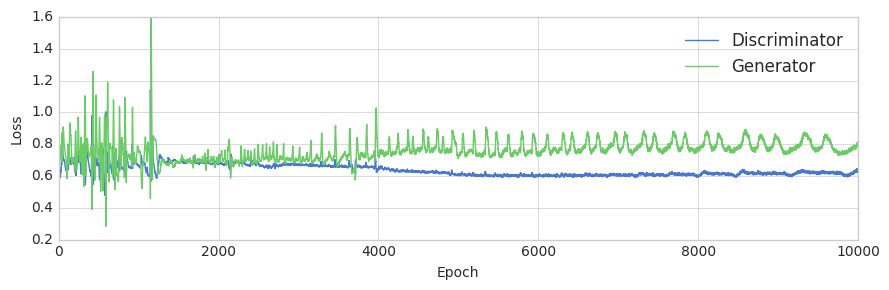

In [18]:
fig, ax = plt.subplots(figsize=(9, 3), tight_layout=True)

ax.plot(loss_history['discriminator'], label='Discriminator')
ax.plot(loss_history['generator'], label='Generator')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

pass

This plot shows the history of the training loss of discriminator and generator.

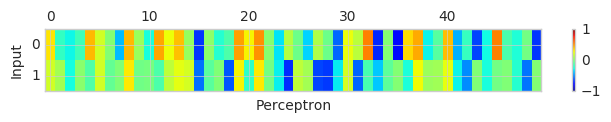

In [22]:
init_layer = discriminator.get_layer('initial_dense')
weight_matrix, bias_vector = init_layer.get_weights()
ones_response = weight_matrix + bias_vector[None, :]

fig, ax = plt.subplots(figsize=(8, 0.8))
im = ax.matshow(ones_response, vmin=-1, vmax=1, cmap='jet', aspect='auto')
ax.set_xlabel('Perceptron')
ax.set_ylabel('Input')
cbar = fig.colorbar(im)
cbar.set_ticks([-1, 0, 1])

pass

And this is the weight matrix of the first layer of the discriminator, biased by the bias vector of the same layer.